# Navier-Stokes Solver using Finite Differences
## CH EN 6355 - Computational Fluid Dynamics
**Prof. Tony Saad (<a>www.tsaad.net</a>) <br/>Department of Chemical Engineering <br/>University of Utah**
<hr/>

In [26]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
plt.rcParams['animation.html'] = 'html5'

In [27]:
'''
Compute first derivative using central differencing on f
'''
def ddx(f, dx):
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[1:-1,2:] - f[1:-1,:-2])/2.0/dx
    return result

def ddy(f, dy):
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[2:,1:-1] - f[:-2,1:-1])/2.0/dy
    return result
    
def laplacian(f, dx, dy):
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[1:-1,2:] - 2.0*f[1:-1,1:-1] + f[1:-1,:-2])/dx/dx \
                      + (f[2:,1:-1] -2.0*f[1:-1,1:-1] + f[:-2,1:-1])/dy/dy
    return result

def div(u,v,dx,dy):
    return ddx(u,dx) + ddy(v,dy)

In [28]:
nx = 32
ny = 32
lx = 1.0
ly = 1.0
dx = lx/(nx-1)
dy = ly/(ny-1)

ν = 0.05
Ut = 1.0 # m/s

dt = min(0.25*dx*dx/ν, 4.0*ν/Ut/Ut)
print('Re =', Ut*lx/ν)
u = np.zeros([ny,nx])
v = np.zeros([ny,nx])
uh = np.zeros([ny,nx])
vh = np.zeros([ny,nx])
p = np.zeros([ny,nx])

Re = 20.0


In [29]:
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    it = 0
    err = 1e5
    tol = 1e-3
    maxit = 50
    while it < maxit and err > tol:
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dy = 0 at right wall
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at the top wall
        err = np.linalg.norm(p - pn, 2)
        it += 1
        
    return p, err

In [30]:
t = 0.0
tend = 4000*dt

while t < tend:
    # set boundary conditions
    # bottom wall
    u[0,:] = 0.0 
    v[0,:] = 0.0     
    # top wall    
    u[-1,:] = Ut
    v[-1,:] = 0.0
    # left wall
    u[:,0] = 0.0
    v[:,0] = 0.0
    # right wall
    u[:,-1] = 0.0
    v[:,-1] = 0.0
        
    # do the x-momentum RHS
    # u rhs: - d(uu)/dx - d(vu)/dy + ν d2(u)
    uRHS = - ddx(u*u,dx) - ddy(v*u,dy) + ν*laplacian(u,dx,dy)
    # v rhs: - d(uv)/dx - d(vv)/dy + ν d2(v)
    vRHS = - ddx(u*v,dx) - ddy(v*v,dy) + ν*laplacian(v,dx,dy)
    
    uh = u + dt*uRHS
    vh = v + dt*vRHS
    
    # next compute the pressure RHS: prhs = div(un)/dt + div( [urhs, vrhs])
    prhs = div(uh,vh,dx,dy)/dt
    p,err = pressure_poisson(p,dx,dy,prhs)
    
    # finally compute the true velocities
    # u_{n+1} = uh - dt*dpdx
    u = uh - dt*ddx(p,dx)
    v = vh - dt*ddy(p,dy)
    t += dt

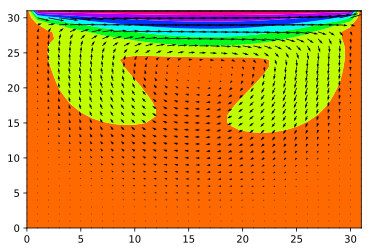

In [31]:
vel =np.sqrt(uh**2 + vh**2)
plt.contourf(vel,cmap='hsv')
plt.quiver(u,v,color='k')   

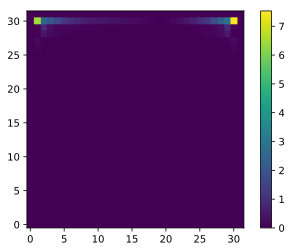

In [32]:
divu = div(u,v,dx,dy)
plt.imshow(abs(divu), origin='bottom')
plt.colorbar()

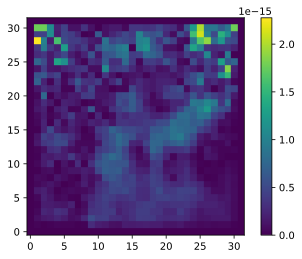

In [23]:
divu = div(uh,vh,dx,dy) - dt * laplacian(p,dx,dy)
plt.imshow(abs(divu), origin='bottom')
plt.colorbar()

In [24]:
import urllib
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get("https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css")
    return HTML(styles.text)
css_styling()

